In [1]:
# PySpark API:
#http://spark.apache.org/docs/latest/api/python/index.html

import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

#import and define spark context
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("appName2")
sc = SparkContext(conf=conf)

#from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql.types import *
#sc= SparkContext()
sqlContext = SQLContext(sc)

#get python and spark versions
import platform
print(platform.python_version())
print(sc.version)

#import python sql libraries and other functions
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

# import python library for plotting data
import matplotlib.pyplot as plt
import gmplot

#import pandas and numpy
import pandas as pd
#import numpy as np

3.6.8
2.4.3


In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when
#from graphframes import *


spark = SparkSession.builder.appName("Data Analysis").config("spark.jars.packages", "graphframes:graphframes:0.6.0-spark2.3-s_2.11").enableHiveSupport().getOrCreate()

sqlContext = SQLContext(spark)

In [3]:
#create dataframe from nottinghamstreet csv file
#https://data.police.uk/data/

nottingham_dfCrime2 = spark.read.option("header", "true").option("delimiter",",")\
.option("inferschema","true").csv("hdfs:///user/imat5322_1396023/*nottinghamshire-street.csv")

In [4]:
nottingham_dfCrime2.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



In [5]:
#tidy up the column name
nottingham_dfCrime2 = nottingham_dfCrime2.withColumnRenamed('Crime ID', 'Crime_ID')
nottingham_dfCrime2 = nottingham_dfCrime2.withColumnRenamed('Reported by', 'Reported')
nottingham_dfCrime2 = nottingham_dfCrime2.withColumnRenamed('Falls within', 'Falls_within')
nottingham_dfCrime2 = nottingham_dfCrime2.withColumnRenamed('LSOA code', 'LSOA_code')
nottingham_dfCrime2 = nottingham_dfCrime2.withColumnRenamed('Crime type', 'Crime_type')
nottingham_dfCrime2 = nottingham_dfCrime2.withColumnRenamed('Last outcome category', 'Last_outcome_category')

In [6]:
#Deep dive into data and  exploration
i = 0
#get total amount records
total = nottingham_dfCrime2.count()
print("Total Records = " + str(total))
#print the amount of column 

print("Total colums = " + str(len(nottingham_dfCrime2.columns)))
print("-----------------------------------------------")
#loop entire table and get the missing rate of each column 
while i < len(nottingham_dfCrime2.columns):
    mv = nottingham_dfCrime2.select([count(when(nottingham_dfCrime2[i].isNull(),True))]).show()
    print(str(i+1) + "," + str(nottingham_dfCrime2))
    print(" missing values =")
    print("-------------------------------------------------------")
    i = i+1

Total Records = 285517
Total colums = 12
-----------------------------------------------
+-------------------------------------------------+
|count(CASE WHEN (Crime_ID IS NULL) THEN true END)|
+-------------------------------------------------+
|                                            82038|
+-------------------------------------------------+

1,DataFrame[Crime_ID: string, Month: string, Reported: string, Falls_within: string, Longitude: double, Latitude: double, Location: string, LSOA_code: string, LSOA name: string, Crime_type: string, Last_outcome_category: string, Context: string]
 missing values =
-------------------------------------------------------
+----------------------------------------------+
|count(CASE WHEN (Month IS NULL) THEN true END)|
+----------------------------------------------+
|                                             0|
+----------------------------------------------+

2,DataFrame[Crime_ID: string, Month: string, Reported: string, Falls_within: string,

In [7]:
#reset counter
i=0
print("-----------------------------------")


#loop each column and get the descriptionof each one
while i < len(nottingham_dfCrime2.columns):
    mv = nottingham_dfCrime2.where(nottingham_dfCrime2[i] =='').count
    print(str(i+1) + "," + str(nottingham_dfCrime2[i]))
    nottingham_dfCrime2.where(nottingham_dfCrime2[i] !='').describe(nottingham_dfCrime2.columns[i]).show()
    print("------------------------")
    i = i+1

-----------------------------------
1,Column<b'Crime_ID'>
+-------+--------------------+
|summary|            Crime_ID|
+-------+--------------------+
|  count|              203479|
|   mean|                null|
| stddev|                null|
|    min|00010fbe8ee71df3e...|
|    max|ffff93ecb1e09042f...|
+-------+--------------------+

------------------------
2,Column<b'Month'>
+-------+-------+
|summary|  Month|
+-------+-------+
|  count| 285517|
|   mean|   null|
| stddev|   null|
|    min|2019-03|
|    max|2021-03|
+-------+-------+

------------------------
3,Column<b'Reported'>
+-------+--------------------+
|summary|            Reported|
+-------+--------------------+
|  count|              285517|
|   mean|                null|
| stddev|                null|
|    min|Nottinghamshire P...|
|    max|Nottinghamshire P...|
+-------+--------------------+

------------------------
4,Column<b'Falls_within'>
+-------+--------------------+
|summary|        Falls_within|
+-------+------

In [8]:
# Get the count for each month ordered in descending order
nottingham_dfCrime2.groupby('Month').count().orderBy(desc('count')).show()

+-------+-----+
|  Month|count|
+-------+-----+
|2019-07|13080|
|2020-05|12702|
|2020-07|12574|
|2019-10|12111|
|2019-08|12066|
|2020-09|11990|
|2019-06|11987|
|2019-05|11945|
|2020-06|11892|
|2019-03|11847|
|2020-08|11824|
|2021-03|11766|
|2020-10|11728|
|2019-04|11606|
|2019-09|11472|
|2020-04|11331|
|2019-11|11209|
|2020-03|11175|
|2020-01|10849|
|2020-02|10730|
+-------+-----+
only showing top 20 rows



In [9]:
#retrieve yearly amount of crimes sorted descendantly
nottingham_dfCrime2.select(substring(nottingham_dfCrime2.Month, 1,4).alias('Year'), "Month")\
.groupby("Year").count().orderBy(desc("count")).show()

+----+------+
|Year| count|
+----+------+
|2020|136557|
|2019|117915|
|2021| 31045|
+----+------+



In [10]:
#created new data frame with month and counts per month
nottingham_dfCrime3 = nottingham_dfCrime2.select(nottingham_dfCrime2.Month).groupby(nottingham_dfCrime2.Month).count()

In [11]:
nottingham_dfCrime3.printSchema()

root
 |-- Month: string (nullable = true)
 |-- count: long (nullable = false)



In [12]:
nottingham_dfCrime3.show()

+-------+-----+
|  Month|count|
+-------+-----+
|2020-06|11892|
|2019-10|12111|
|2020-12| 9282|
|2020-02|10730|
|2019-11|11209|
|2019-03|11847|
|2020-05|12702|
|2021-03|11766|
|2021-02| 9626|
|2019-07|13080|
|2020-11|10480|
|2019-05|11945|
|2020-07|12574|
|2019-08|12066|
|2019-09|11472|
|2020-03|11175|
|2020-01|10849|
|2019-06|11987|
|2019-04|11606|
|2020-09|11990|
+-------+-----+
only showing top 20 rows



In [13]:

nottingham_dfCrime3.registerTempTable("tbl_nottingham_dfCrime3")

In [14]:
# create a dataframe with month total and average 

NottinghammonthlyCrimeAmount = sqlContext.sql("select substring(Month, 6, 2) as Month, SUM(count) as Total, avg(count) as Average from tbl_nottingham_dfCrime3 group by substring(Month, 6, 2)")

In [15]:
NottinghammonthlyCrimeAmount

DataFrame[Month: string, Total: bigint, Average: double]

In [16]:
# Show monthly crime Amount
NottinghammonthlyCrimeAmount.show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   07|25654|12827.0|
|   11|21689|10844.5|
|   01|20502|10251.0|
|   09|23462|11731.0|
|   05|24647|12323.5|
|   08|23890|11945.0|
|   03|34788|11596.0|
|   02|20356|10178.0|
|   06|23879|11939.5|
|   10|23839|11919.5|
|   12|19874| 9937.0|
|   04|22937|11468.5|
+-----+-----+-------+



In [17]:
# Register the MonthlyCrimeAmount
# Dataframe as a temp table and show the contents
NottinghammonthlyCrimeAmount.registerTempTable("monthlyCrimeAmount")
sqlContext.sql("select * from monthlyCrimeAmount").show()

+-----+-----+-------+
|Month|Total|Average|
+-----+-----+-------+
|   07|25654|12827.0|
|   11|21689|10844.5|
|   01|20502|10251.0|
|   09|23462|11731.0|
|   05|24647|12323.5|
|   08|23890|11945.0|
|   03|34788|11596.0|
|   02|20356|10178.0|
|   06|23879|11939.5|
|   10|23839|11919.5|
|   12|19874| 9937.0|
|   04|22937|11468.5|
+-----+-----+-------+



In [18]:
#Prepare variables for visualisations
#visualisation of nottinghamshire dataset

totalArray = sqlContext.sql("select Total from monthlyCrimeAmount").rdd.map(lambda f:f[0]).collect()
monthArray = sqlContext.sql("select Month from monthlyCrimeAmount").rdd.map(lambda f:f[0]). collect()
averageArray = sqlContext.sql("select Average from monthlyCrimeAmount").rdd.map(lambda f:f[0]).collect()


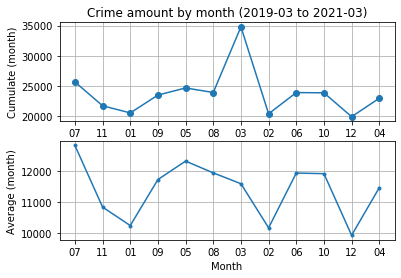

In [19]:
#Plot visualisations
import matplotlib.pyplot as plt
import numpy as np

y = monthArray
t = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by month (2019-03 to 2021-03)')
plt.ylabel('Cumulate (month)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, '.-')
plt.xlabel('Month')
plt.ylabel('Average (month)')
plt.grid(True)
plt.savefig("yearly_Crime_Amount.png")
plt.show()

In [20]:
# Create dataframe to retrieve information by year

yearlyCrimeAmount = sqlContext. sql ("select substring(Month, 0, 4)as Year, SUM(count) as Total, avg(count) as Average from  tbl_nottingham_dfCrime3 group by substring(month, 0, 4)")

In [21]:
yearlyCrimeAmount

DataFrame[Year: string, Total: bigint, Average: double]

In [22]:
# print result of Yearly Crime Amount
yearlyCrimeAmount.show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2020|136557|          11379.75|
|2019|117915|           11791.5|
|2021| 31045|10348.333333333334|
+----+------+------------------+



In [23]:
#Register the yearly data in a temp table and show the content

yearlyCrimeAmount.registerTempTable("yearlyCrimeAmount")
sqlContext.sql("select * from yearlyCrimeAmount").show()

+----+------+------------------+
|Year| Total|           Average|
+----+------+------------------+
|2020|136557|          11379.75|
|2019|117915|           11791.5|
|2021| 31045|10348.333333333334|
+----+------+------------------+



In [24]:
#Prepare variables for visualisations
#visualisation of nottinghamshire dataset

totalArray = sqlContext.sql("select Total from yearlyCrimeAmount").rdd.map(lambda f:f[0]).collect()
yearArray = sqlContext.sql("select Year from YearlyCrimeAmount").rdd.map(lambda f:f[0]). collect()
averageArray = sqlContext.sql("select Average from yearlyCrimeAmount").rdd.map(lambda f:f[0]).collect()


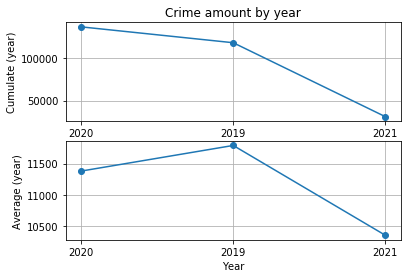

In [25]:
#Plot visualisations

import matplotlib.pyplot as plt
import numpy as np

y = yearArray
t = totalArray
a = averageArray

plt.subplot(2, 1, 1)
plt.plot(y, t, 'o-')
plt.title('Crime amount by year')
plt.ylabel('Cumulate (year)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y, a, 'o-')
plt.xlabel('Year')
plt.ylabel('Average (year)')
plt.grid(True)
plt.savefig("yearly_Crime_Amount.png")
plt.show()

In [26]:
# Create a Tbl Table
nottingham_dfCrime2.registerTempTable("tbl_nottingham_dfCrimeTypes")

In [27]:
#Explore crime types per year/month
NottinghamcrimeTypes = sqlContext.sql("select Crime_type, Month, substring(Month, 0, 4) as year, count(*) as Count from tbl_nottingham_dfCrimeTypes group by Month, Crime_type")

In [28]:
#Print result of crime Types Show CrimeTypes
NottinghamcrimeTypes.show()

+--------------------+-------+----+-----+
|          Crime_type|  Month|year|Count|
+--------------------+-------+----+-----+
|       Bicycle theft|2020-07|2020|  152|
|Criminal damage a...|2019-06|2019|  950|
|            Burglary|2020-06|2020|  452|
|Theft from the pe...|2019-09|2019|  113|
|Violence and sexu...|2021-01|2021| 2438|
|             Robbery|2020-07|2020|   86|
|         Other theft|2019-03|2019|  896|
|Theft from the pe...|2019-08|2019|  124|
|        Public order|2019-09|2019|  628|
|         Other crime|2020-12|2020|  195|
|Criminal damage a...|2019-07|2019| 1107|
|            Burglary|2020-10|2020|  490|
|Criminal damage a...|2020-03|2020|  960|
|Anti-social behav...|2020-09|2020| 3773|
|Criminal damage a...|2021-03|2021|  955|
|            Burglary|2019-08|2019|  625|
|Theft from the pe...|2019-04|2019|  144|
|       Bicycle theft|2020-12|2020|   79|
|       Vehicle crime|2019-06|2019|  667|
|       Bicycle theft|2019-12|2019|  119|
+--------------------+-------+----

In [29]:
import pixiedust

Pixiedust database opened successfully


In [30]:
display(NottinghamcrimeTypes)

In [31]:
display(NottinghamcrimeTypes)


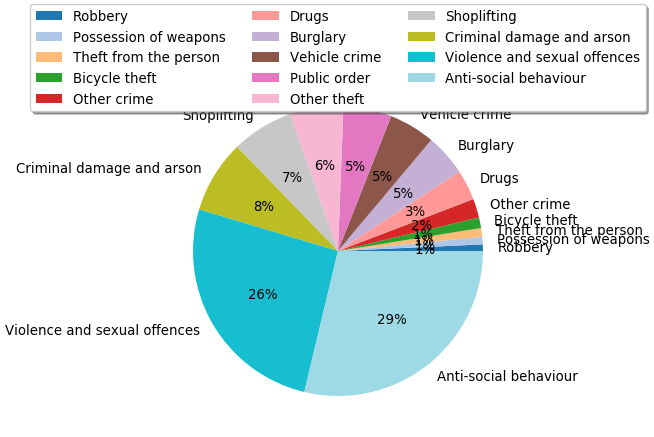

In [ ]:
display(NottinghamcrimeTypes)

In [33]:
#Create a new DataFrame for GeographicalExplore Crime Types per year/month

NottinghamcrimeTypesGeo = sqlContext.sql("select Crime_type, Month, \
substring(Month, 0, 4) as Year, Latitude, Longitude, \
count(*) as Count from tbl_nottingham_dfCrimeTypes group by Month, \
crime_type, Latitude, Longitude")

In [34]:
#Visual January 2021
display(NottinghamcrimeTypesGeo)

In [35]:
#Visual Year 2020
display(NottinghamcrimeTypesGeo)

In [37]:
#Visual Year 2021
display(NottinghamcrimeTypesGeo)

In [38]:
#visual year 2019
display(NottinghamcrimeTypesGeo)


In [39]:
#visual July 2019
display(NottinghamcrimeTypesGeo)

In [40]:
#visual September 2020
display(NottinghamcrimeTypesGeo)